In [18]:
import os
import pandas as pd
import numpy as np
import sqlalchemy
from sqlalchemy import create_engine
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
pd.options.display.max_rows = 200

In [5]:
#Connect to local postgres database
conn = psycopg2.connect(database="delinquency_model", user="" , password="" , host="127.0.0.1") #ommitted login information for privacy
cur = conn.cursor()

In [7]:
#Query to create and populate tables(loans, borrower)
#Tables are in localhost database called delinquency_model
create_table_query = """
DROP TABLE IF EXISTS borrower;
CREATE TABLE borrower (
    Account_Number integer,
    First_Name varchar(100),
    Last_Name varchar(100),
    Zip_Code INTEGER,
    Country_Code varchar(50),
    Income_Annual money,
    Total_Mortgage_Balances integer,
    Total_HE_Balances integer,
    Num_Trades_Past_Due integer,
    Num_He_Trades integer   
);

DROP TABLE IF EXISTS loans;
CREATE TABLE loans (
    Account_Number integer,
    Month timestamp,
    Product varchar(100),
    FICO_Score_Original integer,
    FICO_Score_Current integer,
    Origination_Date timestamp,
    Maturity_Date timestamp,
    Commitments decimal,
    Outstandings decimal,
    LTV_Original decimal,
    LTV_Current decimal,
    Lien_Position varchar(100),
    Day_Past_Due integer,
    Interest_Variability_Code varchar(50),
    Collateral_Value money,
    Payment_Amount money,
    Origination_DTI decimal,
    APR decimal
    
);

COPY borrower FROM '/Users/michaeltan/dev/venv/HELOAN Delinquency Model/Data/borrower.csv' DELIMITER ',' CSV HEADER;
COPY loans FROM '/Users/michaeltan/dev/venv/HELOAN Delinquency Model/Data/loans.csv' DELIMITER ',' CSV HEADER;

"""

In [8]:
#Execute create_table_query
cur.execute(create_table_query)

In [11]:
#Query to clean data
query = '''
--Add new column with days_past_due of next month, used as delinquency training outcome
--join borrower info onto each account 
WITH loans2 AS (

SELECT 
    a.*,
    b.day_past_due as day_past_due_next_month,
    c.total_mortgage_balances,
    c.total_he_balances,
    c.num_trades_past_due,
    c.num_he_trades
    
FROM loans as a
LEFT JOIN loans as b
    ON a.account_number = b.account_number
        AND date_trunc('month', a.month) = date_trunc('month', b.month - interval '1' month)
LEFT JOIN borrower as c
    ON a.account_number = c.account_number
    
),

--clean rows of empty or missing data
clean_rows AS (

SELECT 
    *
FROM loans2
WHERE COALESCE(commitments, apr, fico_score_current, ltv_current) != 0 --no line of credit so not relevant to predicting current customers. will keep APR because high apr represents high risk
    AND COALESCE(loans2.*) is not null
    
),



--Only select columns used as predictors
--Turn day_past_due_next_month into 1(yes) or 0(no) and remove last row with no next month info
--Add column called utilization which = outstandings/commitments
loans3 AS (

SELECT 
    account_number,
    month,
    fico_score_current,
    commitments,
    outstandings,
    (outstandings/commitments) as utilization,
    ltv_current,
    origination_dti,
    apr,
    total_mortgage_balances,
    total_he_balances,
    num_trades_past_due,
    num_he_trades,
    CASE WHEN day_past_due_next_month = 0 THEN 0
        ELSE 1
    END AS delinquent_next_month
FROM clean_rows
WHERE day_past_due_next_month is not null 

)

SELECT * FROM loans3
ORDER BY account_number desc

;
'''

In [12]:
#Store results of query in a dataframe
train_data = pd.read_sql(query, con = conn)
train_data

,account_number,month,fico_score_current,commitments,outstandings,utilization,ltv_current,origination_dti,apr,total_mortgage_balances,total_he_balances,num_trades_past_due,num_he_trades,delinquent_next_month
0,4999,2017-03-31,722,129012.21,141234.42,1.094737,0.490,0.199,0.0393,0,133829,93,3,0
1,4999,2017-04-30,726,135560.48,130138.06,0.960000,0.447,0.199,0.0435,0,133829,93,3,0
2,4999,2017-05-31,712,139361.48,131243.34,0.941748,0.447,0.199,0.0426,0,133829,93,3,0
3,4999,2017-06-30,688,128305.87,128305.87,1.000000,0.462,0.199,0.0414,0,133829,93,3,0
4,4999,2017-07-31,675,141538.98,133451.04,0.942857,0.549,0.199,0.0393,0,133829,93,3,0
5,4998,2017-03-31,682,81592.93,87420.99,1.071428,0.879,0.210,0.0567,0,81498,1,2,0
6,4998,2017-04-30,689,85633.72,84802.32,0.990291,0.870,0.210,0.0539,0,81498,1,2,0
7,4998,2017-05-31,669,85498.12,87158.27,1.019417,0.887,0.210,0.0556,0,81498,1,2,0
8,4998,2017-06-30,651,80401.51,84545.91,1.051546,0.879,0.210,0.0523,0,81498,1,2,0
9,4998,2017-07-31,637,83582.92,80272.71,0.960396,0.862,0.210,0.0534,0,81498,1,2,0


In [13]:
print(train_data.describe())

       account_number  fico_score_current    commitments   outstandings  \
count    11870.000000        11870.000000   11870.000000   11870.000000   
mean      3649.566554          725.737911   46648.184927   46672.958941   
std        862.028423           81.462026   46730.425351   46806.941180   
min       1907.000000          426.000000       0.070000       0.070000   
25%       2947.000000          680.000000   14573.890000   14575.995000   
50%       3756.500000          742.000000   32748.695000   32672.240000   
75%       4383.000000          787.000000   63019.037500   63208.890000   
max       4999.000000          859.000000  408834.770000  421626.070000   

        utilization   ltv_current  origination_dti           apr  \
count  11870.000000  11870.000000     11870.000000  11870.000000   
mean       1.001435      0.343059         0.383428      0.056208   
std        0.044613      0.346419         0.755744      0.020866   
min        0.904740      0.000000         0.000000  

In [19]:
#Normalize data because orders of magnitude between variables are very different
X = train_data.iloc[:,2:13] #independent columns
y = train_data.iloc[:,13] #response column
normalized_X = preprocessing.normalize(X)

In [20]:
#Univariate feature selection

#apply SelectKBest to rank the features
features = SelectKBest(score_func = chi2, k = 'all')
fit = features.fit(normalized_X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for visualization
featureScores = pd.concat([dfcolumns,dfscores],axis=1) 
featureScores.columns = ['feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(11,'Score')) # scores is ratio explained over unexplained

                    feature         Score
7   total_mortgage_balances  1.056932e+01
1               commitments  3.523083e+00
2              outstandings  3.264685e+00
9       num_trades_past_due  4.894662e-01
0        fico_score_current  3.731807e-01
8         total_he_balances  2.072182e-01
5           origination_dti  3.195381e-04
6                       apr  5.229792e-05
10            num_he_trades  2.260873e-05
4               ltv_current  6.184238e-07
3               utilization  2.322580e-09


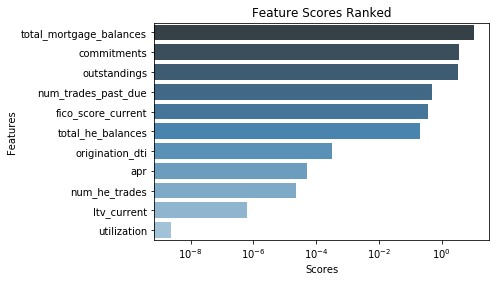

In [814]:
#Horizontal barplot of feature scores

# Get the indices sorted by most important to least important
indices = np.argsort(fit.scores_)[::-1]

# top feature names
features = []
for i in range(11):
    features.append(X.columns[indices[i]])

#Plot using seaborn on log scale
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.invert_yaxis()
ax.set(xlabel='Scores', ylabel='Features', title = 'Feature Scores Ranked')
sns.barplot(fit.scores_[indices[range(11)]], features, palette='Blues_d', orient = 'h', ax = ax)

In [838]:
#Logistic Regression with GridSearchCV tuning (fitting all possible values)
X = train_data.iloc[:,[2, 3, 4, 6, 7, 9, 11]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
clf = GridSearchCV(LogisticRegression(penalty='l2', class_weight = 'balanced'), param_grid)



clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Best score: %.3f" % clf.score(X_test, y_test))
print (classification_report(y_test, y_pred))
    
count = pd.DataFrame(y_test)
count['delinquent_next_month'].value_counts()

Best score: 0.863
              precision    recall  f1-score   support

           0       0.98      0.87      0.92      1114
           1       0.26      0.68      0.38        73

    accuracy                           0.86      1187
   macro avg       0.62      0.78      0.65      1187
weighted avg       0.93      0.86      0.89      1187



0    1114
1      73
Name: delinquent_next_month, dtype: int64

Text(0.5, 15.0, 'Predicted')

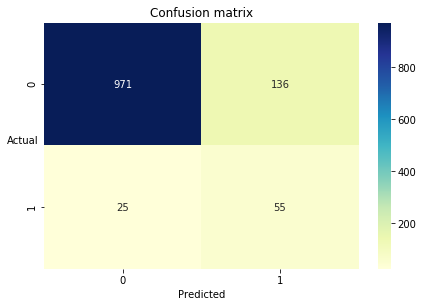

In [837]:
#Confusion matrix, predicted vs actual, heatmap
cnf_matrix = confusion_matrix(y_test,y_pred)

class_names=['current','delinquent'] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual', rotation = 0)
plt.xlabel('Predicted')

In [818]:
#implementation of model
test_data = pd.read_csv() #insert csv file here. Column format: (account_number', 'month', 'fico_score_current', 'commitments', 'outstandings', 'utilization', 'ltv_current', 'origination_dti', 'apr', 'total_mortgage_balances', 'total_he_balances', 'num_trades_past_due', 'num_he_trades')
prediction = clf.predict(test_data)
submission = pd.DataFrame({
    'account_number': test_data['account_number'],
    'delinquent': prediction
})
submission.to_csv('submission.csv', index=False)

TypeError: parser_f() missing 1 required positional argument: 'filepath_or_buffer'